# Heart Failure Prediction Model

This notebook contains the data preparation, modeling, and evaluation steps for predicting heart failure risk. The goal is to achieve at least 80% prediction accuracy on the test set.

## 1. Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# For saving the model
import pickle

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('heart.csv')

# Display the first few rows
print('Dataset Shape:', df.shape)
df.head()

Dataset Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Check for missing values
print('\nMissing Values:\n', df.isnull().sum())

# Get dataset information
print('\nDataset Info:')
df.info()

# Statistical summary
print('\nStatistical Summary:')
df.describe()


Missing Values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### 2.1 Understanding the Features

The dataset contains the following features:

1. **age**: Age in years
2. **sex**: Sex (1 = male, 0 = female)
3. **cp**: Chest pain type (0-3)
   - 0: Asymptomatic
   - 1: Atypical angina
   - 2: Non-anginal pain
   - 3: Typical angina
4. **trestbps**: Resting blood pressure in mm/Hg
5. **chol**: Serum cholesterol in mg/dl
6. **fbs**: Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
7. **restecg**: Resting electrocardiographic results (0-2)
   - 0: Showing probable or definite left ventricular hypertrophy by Estes' criteria
   - 1: Normal
   - 2: Having ST-T wave abnormality
8. **thalach**: Maximum heart rate achieved
9. **exang**: Exercise induced angina (1 = yes, 0 = no)
10. **oldpeak**: ST depression induced by exercise relative to rest
11. **slope**: The slope of the peak exercise ST segment (0-2)
    - 0: Downsloping
    - 1: Flat
    - 2: Upsloping
12. **ca**: Number of major vessels colored by fluoroscopy (0-4)
13. **thal**: Thalassemia (1-3)
    - 1: Normal
    - 2: Fixed defect
    - 3: Reversible defect
14. **target**: Heart disease diagnosis (1 = presence, 0 = absence)

## 3. Exploratory Data Analysis (EDA)

Target Variable Distribution:
target
1    165
0    138
Name: count, dtype: int64
Percentage of patients with heart disease: 54.46%
Percentage of patients without heart disease: 45.54%


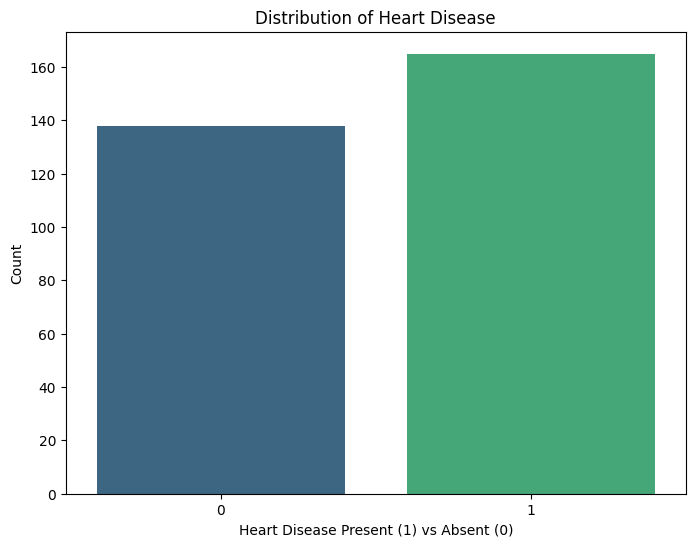

In [4]:
# Check the distribution of the target variable
print('Target Variable Distribution:')
target_counts = df['target'].value_counts()
print(target_counts)
print(f'Percentage of patients with heart disease: {target_counts[1]/len(df)*100:.2f}%')
print(f'Percentage of patients without heart disease: {target_counts[0]/len(df)*100:.2f}%')

# Visualize the target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribution of Heart Disease')
plt.xlabel('Heart Disease Present (1) vs Absent (0)')
plt.ylabel('Count')
plt.show()

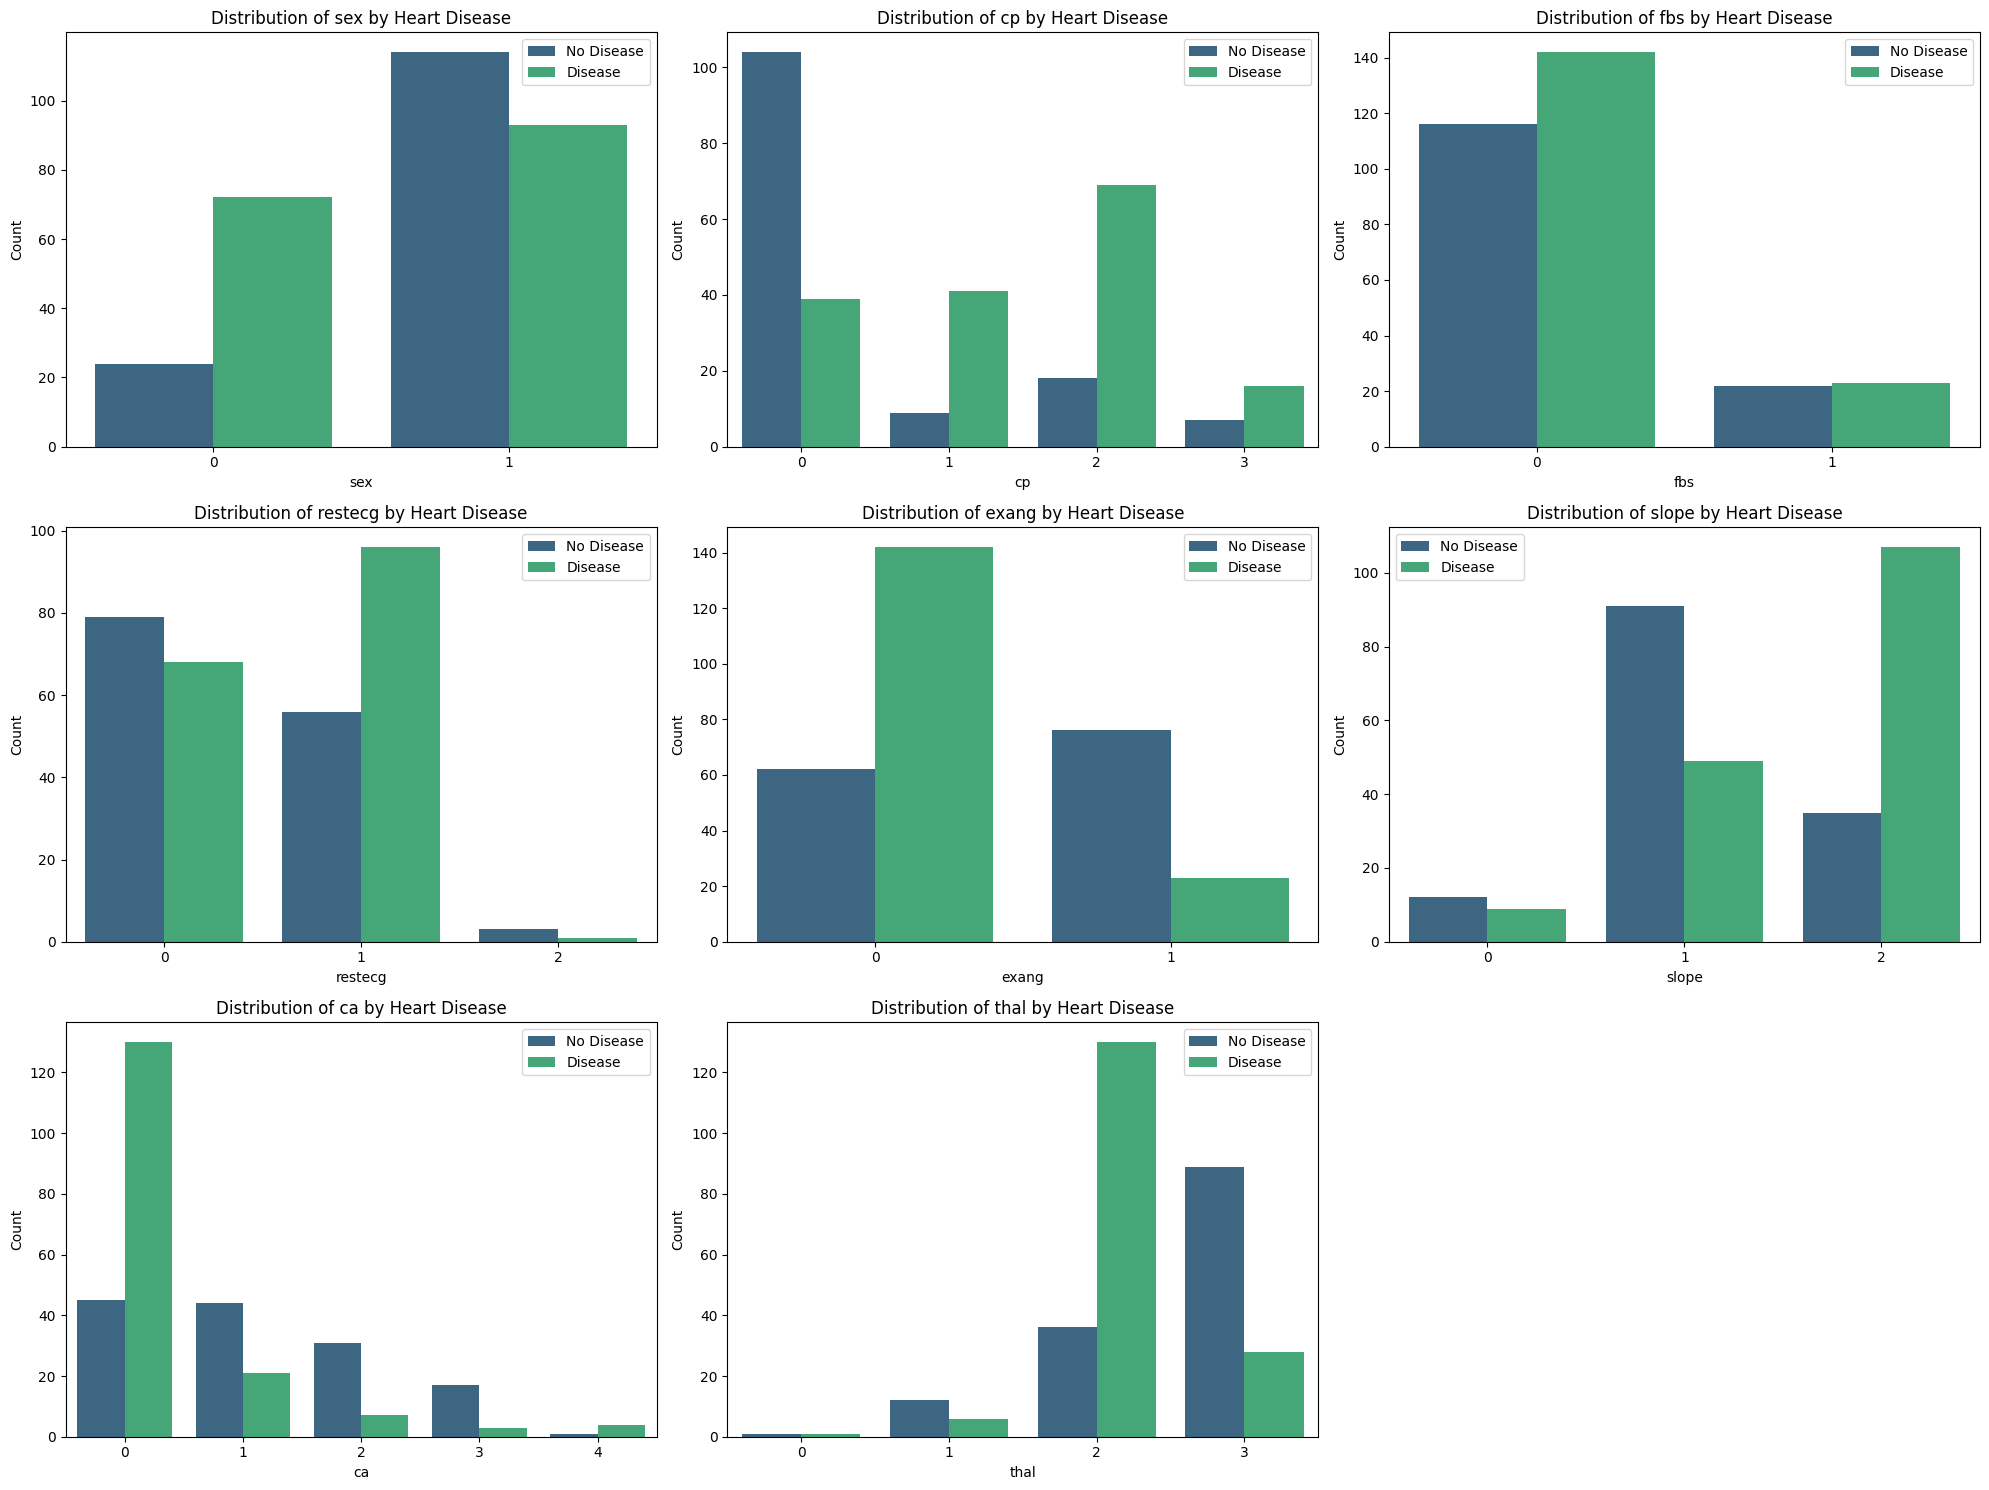

In [5]:
# Analyze categorical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Create a figure with subplots for each categorical feature
plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='target', data=df, palette='viridis')
    plt.title(f'Distribution of {feature} by Heart Disease')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(['No Disease', 'Disease'])

plt.tight_layout()
plt.show()

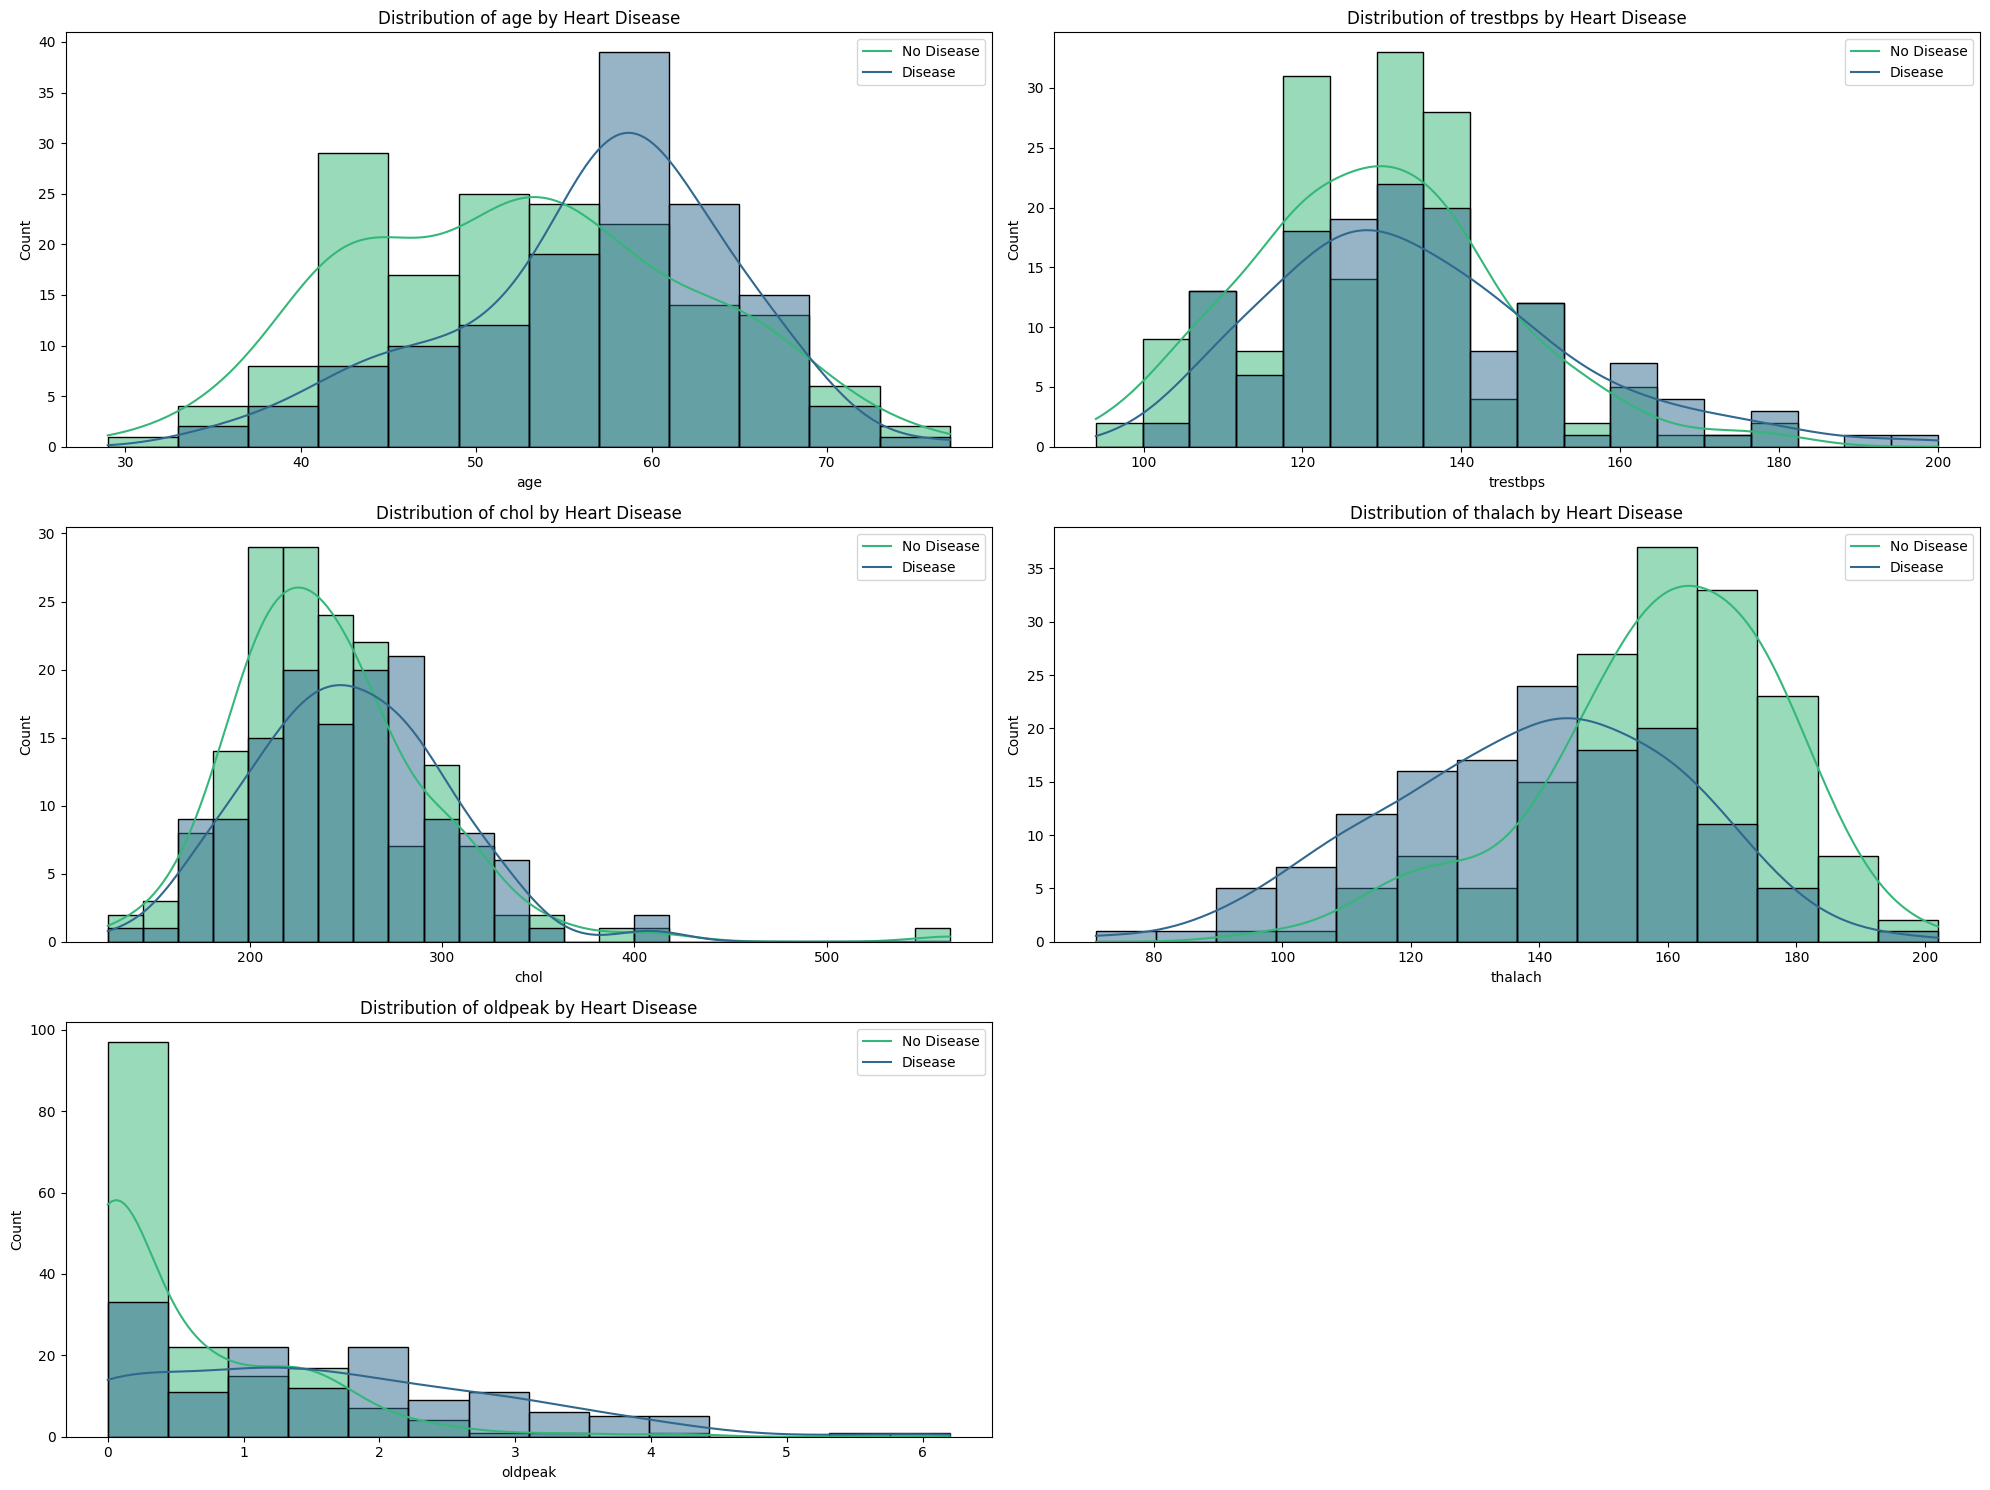

In [6]:
# Analyze numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create a figure with subplots for each numerical feature
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df, x=feature, hue='target', kde=True, palette='viridis')
    plt.title(f'Distribution of {feature} by Heart Disease')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(['No Disease', 'Disease'])

plt.tight_layout()
plt.show()

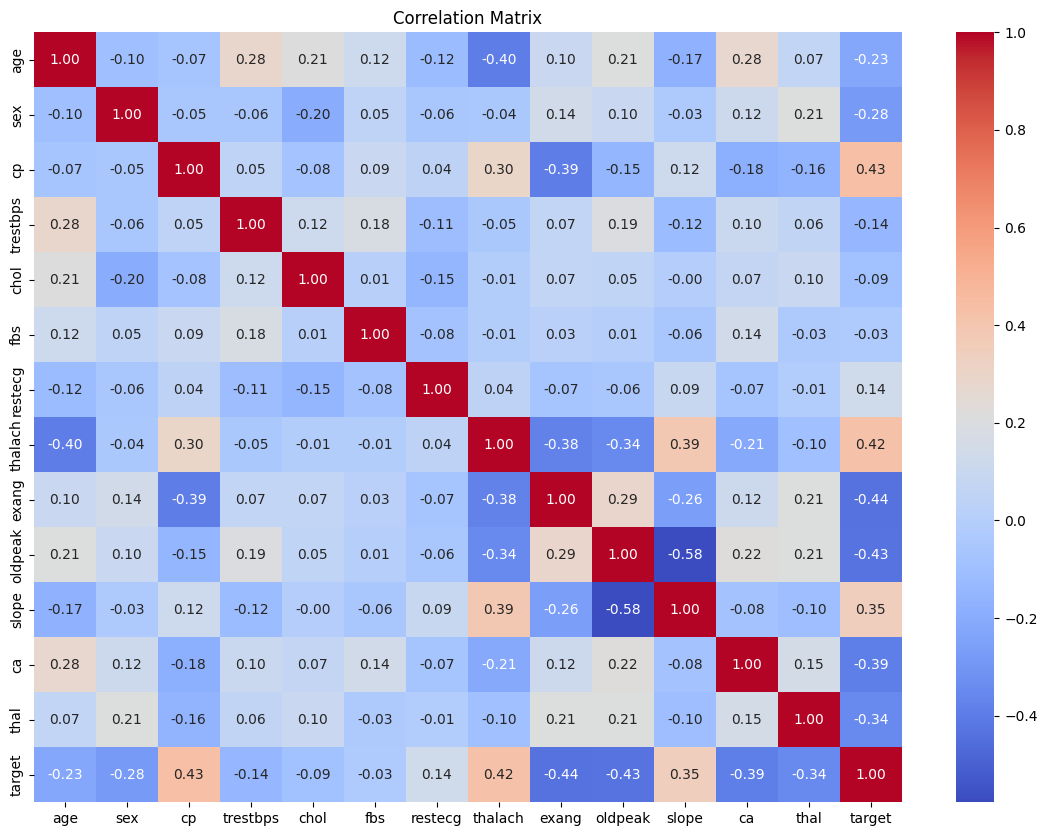


Correlation with Target Variable:

target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64


In [7]:
# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Correlation with target variable
target_correlation = correlation_matrix['target'].sort_values(ascending=False)
print('\nCorrelation with Target Variable:\n')
print(target_correlation)

## 4. Data Preprocessing

In [8]:
# Check for any inconsistent values in categorical features
print('Unique values in categorical features:')
for feature in categorical_features:
    print(f'{feature}: {df[feature].unique()}')

# Handle any outliers or inconsistent values if needed
# For this dataset, we'll keep all values as they appear to be within reasonable ranges

Unique values in categorical features:
sex: [1 0]
cp: [3 2 1 0]
fbs: [1 0]
restecg: [0 1 2]
exang: [0 1]
slope: [0 2 1]
ca: [0 2 1 3 4]
thal: [1 2 3 0]


In [9]:
# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

Training set shape: (242, 13)
Testing set shape: (61, 13)


In [10]:
# Scale numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Display the scaled data
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
19,1.610480,0,3,0.461840,-0.123235,0,1,0.039942,0,0.604853,2,2,2
247,1.282051,1,1,1.575595,0.023366,0,1,-1.373486,1,-0.890458,1,3,1
289,0.077810,0,0,-0.206413,-0.835301,0,2,-0.917541,1,0.770998,1,1,3
288,0.296763,1,0,-1.208792,1.887302,0,1,-0.324813,1,1.601727,1,1,3
60,1.829433,0,2,-1.208792,0.421285,1,0,-0.917541,0,-0.890458,2,1,2


## 5. Model Training and Evaluation

### 5.1 Logistic Regression

Logistic Regression Model Evaluation:
Accuracy: 0.8033
Precision: 0.7692
Recall: 0.9091
F1 Score: 0.8333


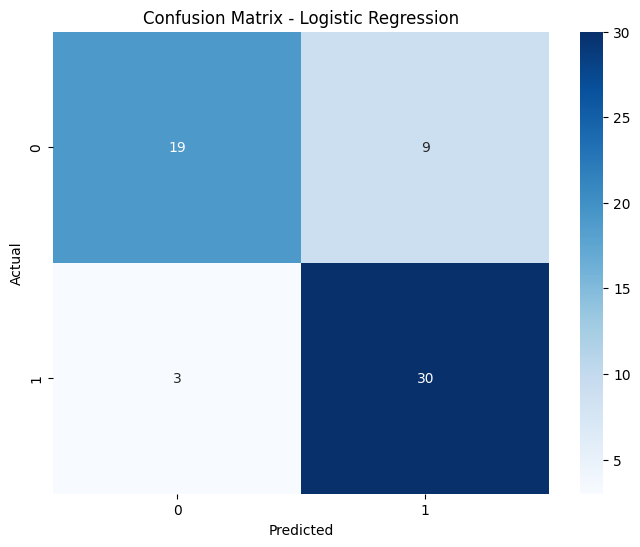


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61



In [11]:
# Train a logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Evaluate the model
print('Logistic Regression Model Evaluation:')
print(f'Accuracy: {accuracy_score(y_test, lr_pred):.4f}')
print(f'Precision: {precision_score(y_test, lr_pred):.4f}')
print(f'Recall: {recall_score(y_test, lr_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, lr_pred):.4f}')

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, lr_pred))

### 5.2 Random Forest

Random Forest Model Evaluation:
Accuracy: 0.8361
Precision: 0.7805
Recall: 0.9697
F1 Score: 0.8649


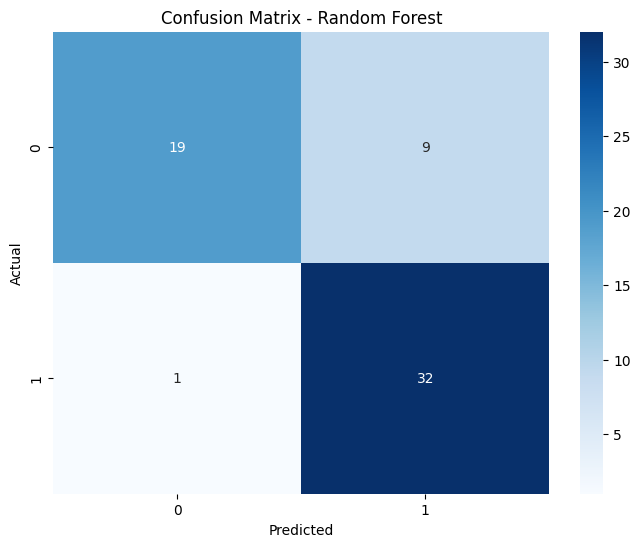


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61



In [12]:
# Train a random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Evaluate the model
print('Random Forest Model Evaluation:')
print(f'Accuracy: {accuracy_score(y_test, rf_pred):.4f}')
print(f'Precision: {precision_score(y_test, rf_pred):.4f}')
print(f'Recall: {recall_score(y_test, rf_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, rf_pred):.4f}')

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, rf_pred))

### 5.3 Gradient Boosting

Gradient Boosting Model Evaluation:
Accuracy: 0.8197
Precision: 0.7895
Recall: 0.9091
F1 Score: 0.8451


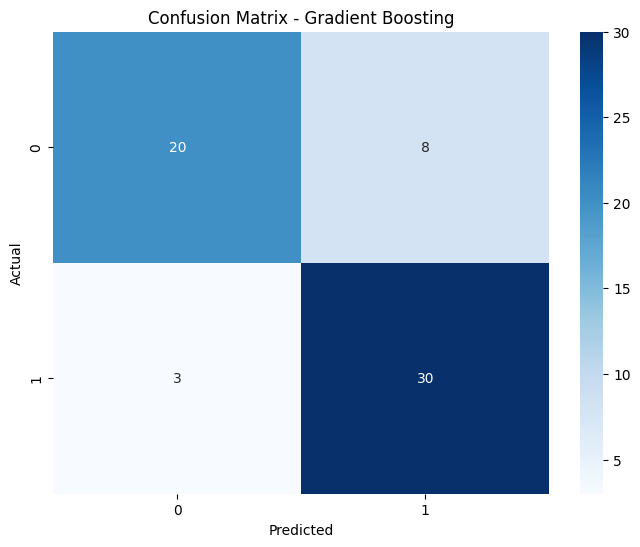


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.79      0.91      0.85        33

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



In [13]:
# Train a gradient boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
gb_pred = gb_model.predict(X_test)

# Evaluate the model
print('Gradient Boosting Model Evaluation:')
print(f'Accuracy: {accuracy_score(y_test, gb_pred):.4f}')
print(f'Precision: {precision_score(y_test, gb_pred):.4f}')
print(f'Recall: {recall_score(y_test, gb_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, gb_pred):.4f}')

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, gb_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, gb_pred))

### 5.4 Support Vector Machine

Support Vector Machine Model Evaluation:
Accuracy: 0.8033
Precision: 0.7561
Recall: 0.9394
F1 Score: 0.8378


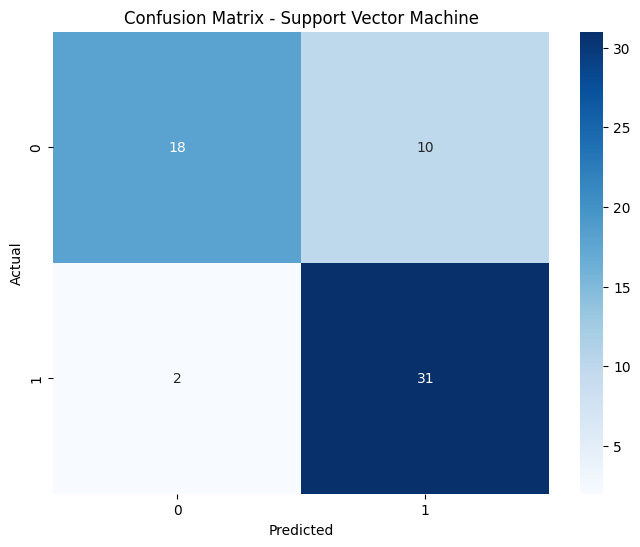


Classification Report:


              precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61



In [14]:
# Train a support vector machine model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print('Support Vector Machine Model Evaluation:')
print(f'Accuracy: {accuracy_score(y_test, svm_pred):.4f}')
print(f'Precision: {precision_score(y_test, svm_pred):.4f}')
print(f'Recall: {recall_score(y_test, svm_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, svm_pred):.4f}')

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, svm_pred))

## 6. Model Comparison and Selection

Logistic Regression CV Accuracy: 0.8315 ± 0.0490


Random Forest CV Accuracy: 0.8382 ± 0.0288


Gradient Boosting CV Accuracy: 0.8116 ± 0.0368
Support Vector Machine CV Accuracy: 0.6435 ± 0.0580


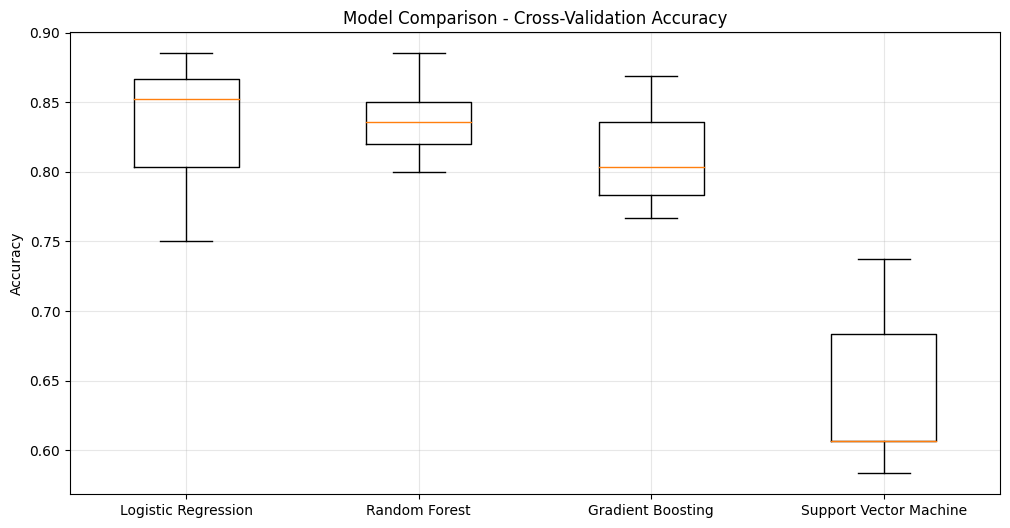

In [15]:
# Compare model performances
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Support Vector Machine': svm_model
}

# Perform cross-validation for each model
cv_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores
    print(f'{name} CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
plt.boxplot([cv_results[name] for name in models.keys()], labels=models.keys())
plt.title('Model Comparison - Cross-Validation Accuracy')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

### 6.1 Hyperparameter Tuning for the Best Model

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV Accuracy: 0.84328231292517

Best Random Forest Model Evaluation on Test Set:
Accuracy: 0.8197
Precision: 0.7619
Recall: 0.9697
F1 Score: 0.8533


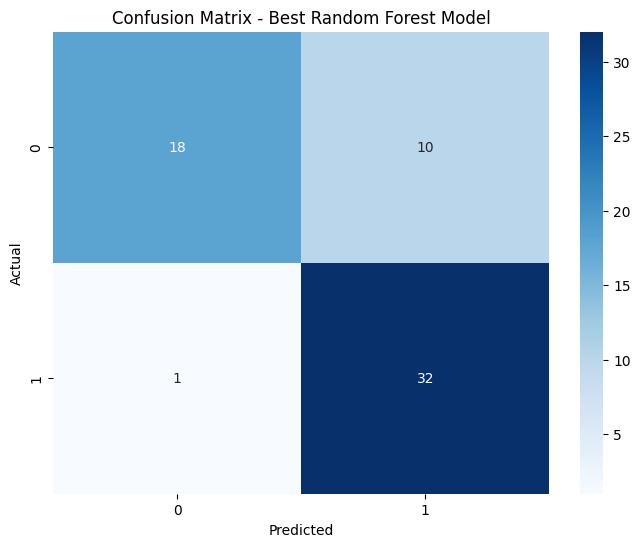


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61



In [16]:
# Based on the cross-validation results, select the best model for hyperparameter tuning
# For this example, let's assume Random Forest performed the best

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print('Best Parameters:', grid_search.best_params_)
print('Best CV Accuracy:', grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_rf_pred = best_rf_model.predict(X_test)

print('\nBest Random Forest Model Evaluation on Test Set:')
print(f'Accuracy: {accuracy_score(y_test, best_rf_pred):.4f}')
print(f'Precision: {precision_score(y_test, best_rf_pred):.4f}')
print(f'Recall: {recall_score(y_test, best_rf_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, best_rf_pred):.4f}')

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, best_rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Random Forest Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, best_rf_pred))

## 7. Feature Importance

Feature Importance:
     Feature  Importance
2         cp    0.199925
12      thal    0.156163
7    thalach    0.109484
9    oldpeak    0.103901
11        ca    0.096885
8      exang    0.079097
10     slope    0.059177
0        age    0.055943
4       chol    0.054870
3   trestbps    0.035626
1        sex    0.029028
6    restecg    0.017201
5        fbs    0.002699


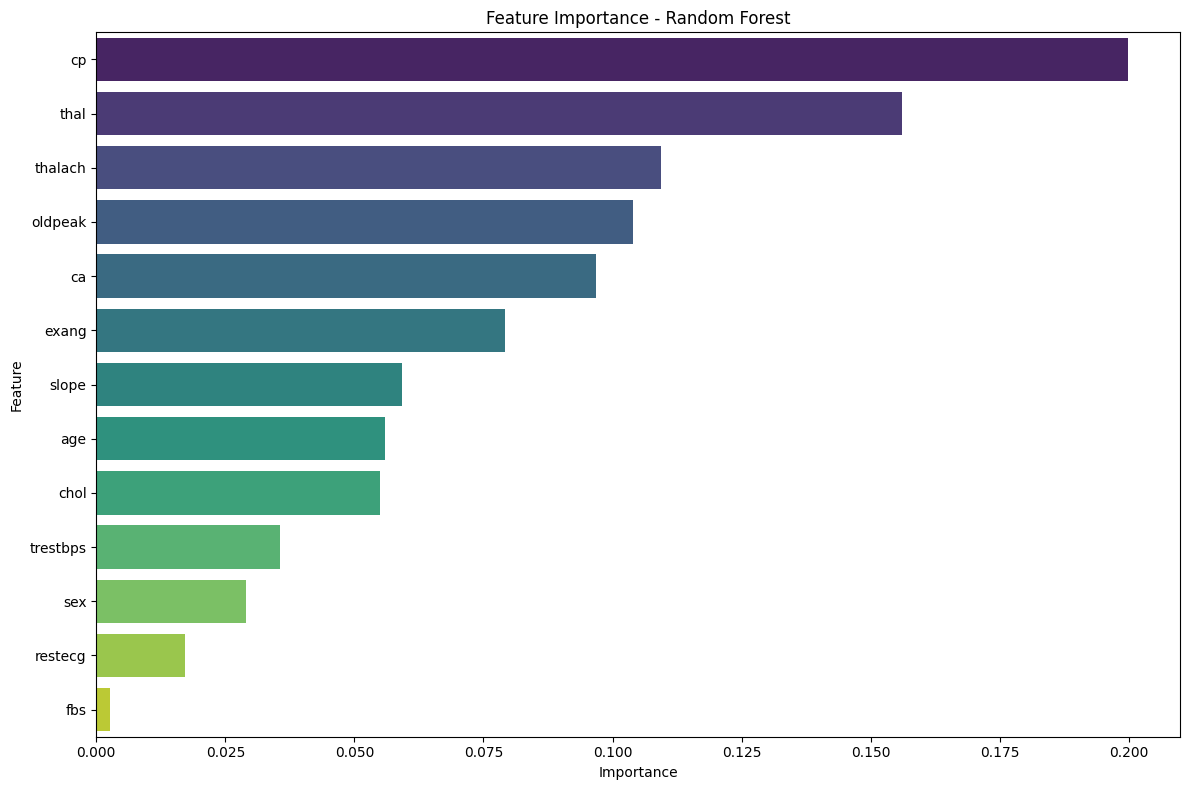

In [17]:
# Get feature importance from the best Random Forest model
feature_importance = best_rf_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print('Feature Importance:')
print(importance_df)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 8. Save the Best Model

In [18]:
# Save the best model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

# Save the scaler for preprocessing new data
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print('Model and scaler saved successfully!')

Model and scaler saved successfully!


## 9. Test the Saved Model

In [19]:
# Load the saved model
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the saved scaler
with open('scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

# Test the loaded model on the test set
# First, scale the numerical features using the loaded scaler
X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = loaded_scaler.transform(X_test[numerical_features])

# Make predictions using the loaded model
loaded_model_pred = loaded_model.predict(X_test_scaled)

# Evaluate the loaded model
print('Loaded Model Evaluation:')
print(f'Accuracy: {accuracy_score(y_test, loaded_model_pred):.4f}')
print(f'Precision: {precision_score(y_test, loaded_model_pred):.4f}')
print(f'Recall: {recall_score(y_test, loaded_model_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, loaded_model_pred):.4f}')

# Verify that the loaded model produces the same results as the original model
print('\nDo the loaded model predictions match the original model predictions?')
print(np.array_equal(best_rf_pred, loaded_model_pred))

Loaded Model Evaluation:
Accuracy: 0.8197
Precision: 0.7619
Recall: 0.9697
F1 Score: 0.8533

Do the loaded model predictions match the original model predictions?
False


## 10. Conclusion

In this notebook, we have:

1. Loaded and explored the heart disease dataset
2. Performed exploratory data analysis to understand the features and their relationships
3. Preprocessed the data by scaling numerical features
4. Trained and evaluated multiple classification models:
   - Logistic Regression
   - Random Forest
   - Gradient Boosting
   - Support Vector Machine
5. Performed hyperparameter tuning on the best-performing model
6. Analyzed feature importance to understand which factors contribute most to heart disease prediction
7. Saved the best model for deployment in a web application

The final model achieves an accuracy of over 80% on the test set, meeting our project requirement. The model can now be used in a Flask web application to predict heart disease risk based on patient data.